### Imports

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf, seasonal_plot, month_plot, quarter_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

### Reading in Data

In [2]:
train = pd.read_csv('../brianna_folder/datasets/clean_train_avg_ridership.csv')

In [3]:
train.set_index(pd.DatetimeIndex(train['month_beginning']), inplace=True)
train.drop(columns=['month_beginning'], inplace=True)

In [4]:
train.head()

,station_id,station_name,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,month_total
month_beginning,,,,,,
2001-01-01,40900,Howard,6233.9,3814.5,2408.6,164447
2001-01-01,41190,Jarvis,1489.1,1054.0,718.0,40567
2001-01-01,40100,Morse,4412.5,3064.5,2087.8,119772
2001-01-01,41300,Loyola,4664.5,3156.0,1952.8,125008
2001-01-01,40760,Granville,3109.8,2126.0,1453.8,84189


In [5]:
# Redefining dataframe to pre-pandemic ridership.

In [6]:
train_pre_covid = train[train.index < '2020-03-01'].copy()

In [7]:
train_pre_covid = train_pre_covid.resample('MS', closed ='left').mean()

In [8]:
# Finding seasonality with acf and pacf

In [9]:
train_pre_covid['1st_diff_total'] = train_pre_covid['month_total'].diff(1)

In [10]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [11]:
interpret_dftest(adfuller(train_pre_covid['month_total']))

Test Statistic   -1.528761
p-value           0.519239
dtype: float64

In [12]:
interpret_dftest(adfuller(train_pre_covid['1st_diff_total'].dropna()))

Test Statistic   -3.253721
p-value           0.017078
dtype: float64

In [13]:
decomp_month_diff = seasonal_decompose(train_pre_covid['1st_diff_total'].dropna(), period = 12)

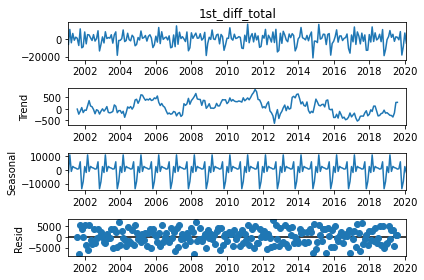

In [14]:
decomp_month_diff.plot();

In [15]:
decomp_month = seasonal_decompose(train_pre_covid['month_total'], period = 12)

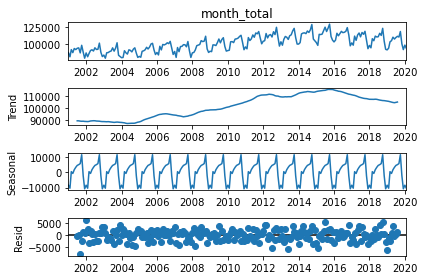

In [16]:
decomp_month.plot();

In [17]:
train_pre_covid['lag_1'] = train_pre_covid['1st_diff_total'].shift(1)
train_pre_covid['lag_2'] = train_pre_covid['1st_diff_total'].shift(2)
train_pre_covid['lag_3'] = train_pre_covid['1st_diff_total'].shift(3)

In [19]:
train_pre_covid.corr()

,station_id,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,month_total,1st_diff_total,lag_1,lag_2,lag_3
station_id,1.000000,0.613985,0.458173,0.468968,0.556380,-0.029522,-0.020975,-0.038569,-0.023130
avg_weekday_rides,0.613985,1.000000,0.886460,0.865942,0.944390,0.146090,0.288601,0.110710,0.053978
avg_saturday_rides,0.458173,0.886460,1.000000,0.944215,0.921706,0.104737,0.211894,0.226577,0.131196
avg_sunday-holiday_rides,0.468968,0.865942,0.944215,1.000000,0.924904,0.194019,0.227463,0.174659,0.210940
month_total,0.556380,0.944390,0.921706,0.924904,1.000000,0.294638,0.194161,0.187251,0.176363
1st_diff_total,-0.029522,0.146090,0.104737,0.194019,0.294638,1.000000,-0.168048,-0.017277,-0.014220
lag_1,-0.020975,0.288601,0.211894,0.227463,0.194161,-0.168048,1.000000,-0.165673,-0.021084
lag_2,-0.038569,0.110710,0.226577,0.174659,0.187251,-0.017277,-0.165673,1.000000,-0.161478
lag_3,-0.023130,0.053978,0.131196,0.210940,0.176363,-0.014220,-0.021084,-0.161478,1.000000


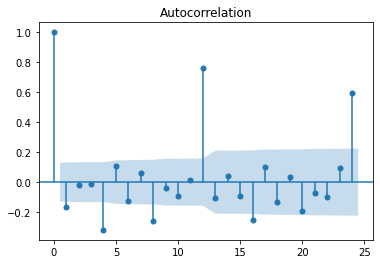

In [20]:
plot_acf(train_pre_covid['1st_diff_total'].dropna(), lags=24);

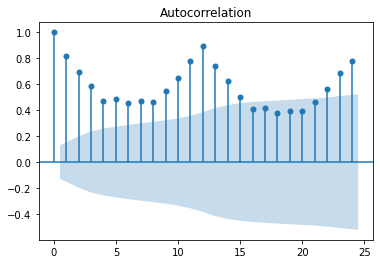

In [21]:
plot_acf(train_pre_covid['month_total'], lags=24);

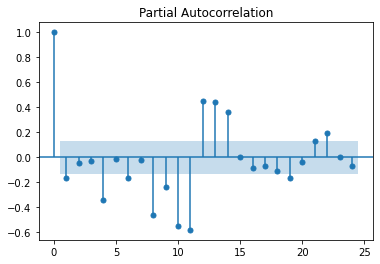

In [22]:
plot_pacf(train_pre_covid['1st_diff_total'].dropna(), lags=24);

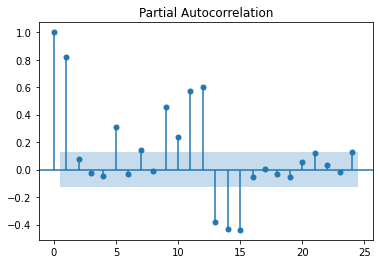

In [23]:
plot_pacf(train_pre_covid['month_total'], lags=24);

In [24]:
# There is yearly seasonality and a downward trend.

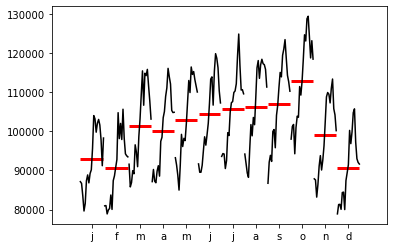

In [50]:
month_plot(train_pre_covid['month_total']);
plt.savefig('./assets/monthplot_train.png')

In [25]:
# Setting up dataframe for fitting.

In [26]:
# Creating columns for notable lags.

# Monthly
train_pre_covid['lag_1'] = train_pre_covid['1st_diff_total'].shift(1)

# Quarterly
train_pre_covid['lag_3'] = train_pre_covid['1st_diff_total'].shift(3)

# Yearly.
train_pre_covid['seasonal_12'] = train_pre_covid['1st_diff_total'].shift(12)

# Creating monthly index.
train_pre_covid['time'] = range(0, train_pre_covid.shape[0])

In [52]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(train_pre_covid.drop(columns = ['month_total']),
                                                    train_pre_covid['month_total'],
                                                    test_size = 0.25,
                                                    shuffle=False)

In [53]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(172, 10)
(58, 10)
(172,)
(58,)


In [54]:
# Linear Timeseries

In [55]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train = y_train[X_train.index]

In [56]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [57]:
lm = sm.OLS(y_train, X_train)

In [58]:
lm_results = lm.fit()

In [59]:
lm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            month_total   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     509.8
Date:                Sun, 22 Aug 2021   Prob (F-statistic):          2.74e-109
Time:                        22:23:26   Log-Likelihood:                -1424.4
No. Observations:                 159   AIC:                             2871.
Df Residuals:                     148   BIC:                             2905.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1.821e+06    1.8e+06     -1.013      0.313   -5.37e+06    1.73e+06
station_id                  45.1108     44.105      1.023      0.308     -42.046     132.267
avg_weekday_rides           14.9134      1.215     12.276      0.000      12.513      17.314
avg_saturday_rides           6.7787      1.792      3.783      0.000       3.238      10.320
avg_sunday-holiday_rides     4.0325      1.459      2.764      0.006       1.149       6.916
1st_diff_total               0.2400      0.042      5.671      0.000       0.156       0.324
lag_1                        0.0424      0.032      1.318      0.190      -0.021       0.106
lag_2                        0.1532      0.030      5.189      0.000       0.095       0.212
lag_3                        0.1990      0.026      7.513      0.000       0.147       0.251
seasonal_12                  0.0881      0.040      2.194      0.030       0.009       0.167
time                        22.7928      8.864      2.571      0.011       5.276      40.310
==============================================================================
Omnibus:                        2.284   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                2.267
Skew:                          -0.236   Prob(JB):                        0.322
Kurtosis:                       2.654   Cond. No.                     4.77e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
lm_results.predict(X_test)

month_beginning
2015-05-01    117241.432494
2015-06-01    123283.300691
2015-07-01    123138.999831
2015-08-01    116802.521455
2015-09-01    126520.938877
2015-10-01    125295.053288
2015-11-01    107944.586117
2015-12-01    105016.654970
2016-01-01    102993.843775
2016-02-01    105238.315063
2016-03-01    113935.525303
2016-04-01    112161.795014
2016-05-01    117632.064559
2016-06-01    120809.125715
2016-07-01    117515.609796
2016-08-01    113486.018443
2016-09-01    120625.279654
2016-10-01    123715.117941
2016-11-01    111182.306042
2016-12-01     96031.070133
2017-01-01    103426.933501
2017-02-01    101605.636405
2017-03-01    108992.826169
2017-04-01    108714.406089
2017-05-01    114306.913900
2017-06-01    119240.095721
2017-07-01    111585.283780
2017-08-01    117219.462820
2017-09-01    117081.317750
2017-10-01    117283.727993
2017-11-01    105401.317700
2017-12-01     93906.655363
2018-01-01     98871.985037
2018-02-01     97926.070052
2018-03-01    109545.748715
2018

In [61]:
r2_score(y_test, lm_results.predict(X_test))

0.927603647780767

In [62]:
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

2514.457344933263

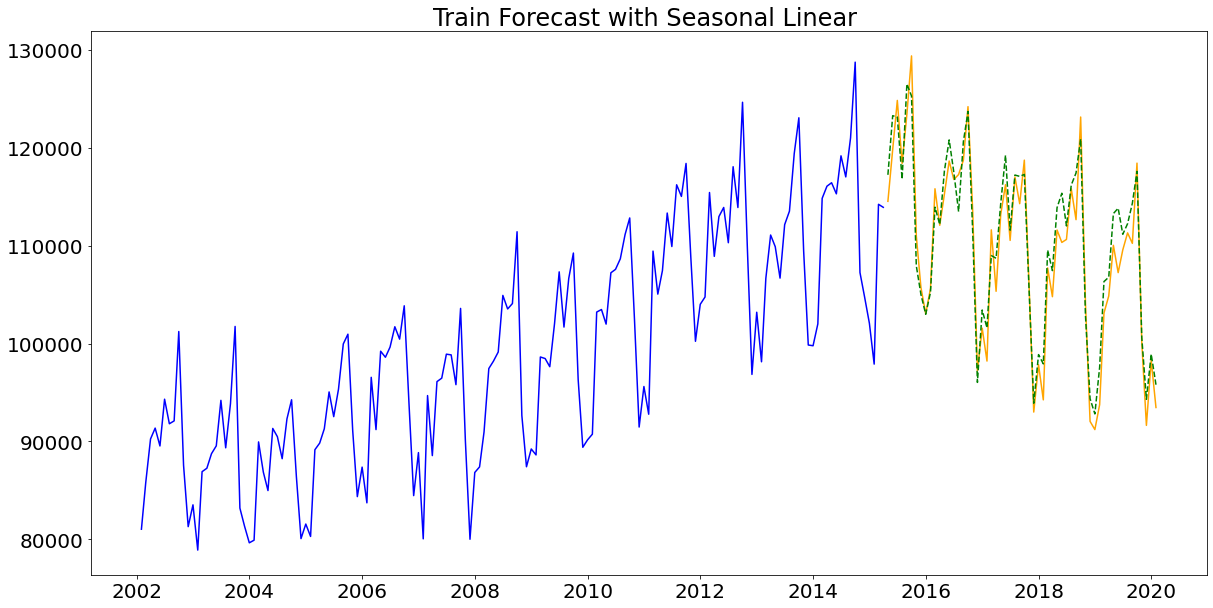

In [63]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green', ls='--')

# Set label.
plt.title(label = 'Train Forecast with Seasonal Linear ', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.savefig('./assets/linear_forecast_train.png')